In [1]:
from pygoose import *

In [2]:
import datetime

In [3]:
import os

In [4]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split

from mlxtend.classifier import StackingCVClassifier, StackingClassifier
import numpy as np

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Config

Automatically discover the paths to various data folders and compose the project structure.

In [5]:
project = kg.Project.discover()

In [6]:
NUM_FOLDS = 5

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Read Data


In [8]:
feature_lists = [
    'simple_summaries',
    'jaccard_ngrams',
    'fuzzy',
    'tfidf',
    #'lda',
    'nlp_tags',
    'wordnet_similarity',
    'phrase_embedding',
    'wmd',
    'wm_intersect',
    
    '3rdparty_abhishek',
    '3rdparty_dasolmar_whq',
    '3rdparty_mephistopheies',
    '3rdparty_image_similarity',
    
    'magic_pagerank',
    'magic_frequencies',
    #'magic_cooccurrence_matrix',
    'magic_cooccurrence_matrix_raw',
    
    'oofp_nn_mlp_with_magic',
    'oofp_nn_cnn_with_magic',
    'oofp_nn_bi_lstm_with_magic',
    'oofp_nn_siamese_lstm_attention',
    
    'wordmatchshare',
]

In [9]:
df_train, df_test, feature_list_ix = project.load_feature_lists(feature_lists)

## Handle the missing/inf data

In [35]:
remove_invalid_feats = True

In [36]:
def find_missing_cols(df):
    null_columns=df.columns[df.isnull().any()]
    display(df[null_columns].isnull().sum())

In [37]:
find_missing_cols(df_train)

pos_tag_cosine               33
abh_cosine_distance        1778
abh_jaccard_distance        522
abh_braycurtis_distance     522
das_word_match              437
das_word_match_2root        437
das_cosine                  784
das_avg_word_len1             1
das_avg_word_len2             2
das_diff_avg_word             3
dtype: int64

In [38]:
find_missing_cols(df_test)

pos_tag_cosine               736
abh_cosine_distance        37232
abh_jaccard_distance        1445
abh_braycurtis_distance     1445
das_word_match              5311
das_word_match_2root        5311
das_cosine                 10131
das_avg_word_len1              2
das_avg_word_len2              4
das_diff_avg_word              6
dtype: int64

In [39]:
if remove_invalid_feats:
    df_train = df_train.replace([np.inf, -np.inf], np.nan)
    df_test = df_test.replace([np.inf, -np.inf], np.nan)
    df_train.dropna(axis=1, inplace=True) 
    df_test.dropna(axis=1, inplace=True)

In [40]:
X_train = df_train.values
X_test = df_test.values
y_train = kg.io.load(project.features_dir + 'y_train.pickle')

In [41]:
print('X train:', X_train.shape)
print('X test: ', X_test.shape)
print('y train:', y_train.shape)

X train: (404290, 170)
X test:  (2345796, 170)
y train: (404290,)


In [42]:
pd.DataFrame(feature_list_ix, columns=['feature_list', 'start_index', 'end_index'])

,feature_list,start_index,end_index
0,simple_summaries,0,8
1,jaccard_ngrams,9,23
2,fuzzy,24,30
3,tfidf,31,32
4,nlp_tags,33,68
5,wordnet_similarity,69,70
6,phrase_embedding,71,76
7,wmd,77,77
8,wm_intersect,78,79
9,3rdparty_abhishek,80,95


## Feature scaling (possibly used for computational models)

In [54]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)  ### fit using training data ####
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Train/predict with single models

### LightGBM

In [18]:
lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 158,
        'lambda_l2': 50,
        'learning_rate': 0.01,
        #'num_boost_round': 5000,
        #'early_stopping_rounds': 10,
        'verbose': 1,
        'bagging_fraction_seed': RANDOM_SEED,
        'feature_fraction_seed': RANDOM_SEED,
    }

train_data = lgb.Dataset(data = X_train, label = y_train, feature_name = df_train.columns.tolist())

#lgb.cv(lgb_params, train_data,  num_boost_round=5000, early_stopping_rounds=10, verbose_eval=100) ## find the best num_rounds

#n_estimators = 3600

In [19]:
%%time
lgb_clf = lgb.train(lgb_params, train_data,  num_boost_round=3600, verbose_eval=100)

CPU times: user 52min 23s, sys: 54.1 s, total: 53min 17s
Wall time: 15min 7s


In [20]:
%%time
y_test_lgb = lgb_clf.predict(X_test).reshape(-1)

CPU times: user 1h 34min 13s, sys: 36.3 s, total: 1h 34min 49s
Wall time: 27min 34s


### Xgboost

In [18]:
xgb_params={
    'max_depth':8,
    'nthread':14,
    'eta':0.05,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'subsample':0.8,
    'colsample_bytree':0.7,
    'silent':1,
    #'seed':1123,
    'gamma':0.005,
    'min_child_weight':1
    'max_delta_step':1 ### need it for class imbalance
}

train_data = xgb.DMatrix(data = X_train, label = y_train)
#xgb.cv(xgb_params, train_data,  num_boost_round=5000, early_stopping_rounds=10, verbose_eval=10)

# Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=0)
# clf_xgb = xgb.XGBClassifier(max_depth=8, learning_rate=0.05, subsample=0.8, colsample_bytree=0.7, gamma=0.005, 
#                            n_estimators=5000)
# clf_xgb.fit(Xtrain, ytrain, early_stopping_rounds=10, eval_metric="logloss",
#         eval_set=[(Xval, yval)], verbose=True)


### n_estimators = 640

In [19]:
%%time
xgb_clf = xgb.train(xgb_params, train_data,  num_boost_round=640, verbose_eval=100)

CPU times: user 1h 31min 23s, sys: 6.31 s, total: 1h 31min 29s
Wall time: 1h 31min 35s


In [36]:
%%time
test_data = xgb.DMatrix(data=X_test)
y_test_xgb = xgb_clf.predict(test_data, ntree_limit=640).reshape(-1)

CPU times: user 3min 33s, sys: 23.9 s, total: 3min 57s
Wall time: 4min 11s


### Grid search for other models (not used due to time cost)

In [38]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# computational_model_hyperparams = {
#     #"KNN" : (KNeighborsClassifier(n_jobs=-1), {"n_neighbors":[5,10,20,80,100,150,200]}),
#     #"LinearSVM" : (LinearSVC(verbose=1), {"C":[0.01, 0.1, 1, 10]}),
#     "LR": (LogisticRegression(n_jobs=-1, solver='sag', verbose=1), {"penalty":["l1", "l2"], "C":[0.01, 0.1, 1, 10]}), 
#     "RbfSVM" : (SVC(verbose=1), {'C': [0.01, 0.1, 1, 10, ], 'gamma': ["auto", 0.001, 0.01, 0.1, 1, 10]}),
# }

# tree_model_hyperparams = {
# #     "DT" : (DecisionTreeClassifier(), {"criterion":['gini', "entropy"], "max_depth":[2, 5, 10, 20, 30], "min_samples_split":[2,5,8,10,12], 
# #                                 "min_samples_leaf" : [1,4,8,10,12,20]}),
#     "RF" : (RandomForestClassifier(n_jobs=-1, verbose=1), {"max_features":['auto', 'sqrt', "log2"], "max_depth":[2, 5, 10, 20, 30], "min_samples_split":[2,5,8,10,12,20], 
#                                 "min_samples_leaf" : [1,5,10,15,20], 'n_estimators': [100, 200, 500, 800]}),
#     "GB" : (GradientBoostingClassifier(verbose=1), {"max_features":['auto', 'sqrt', "log2", None], 'learning_rate':[0.01, 0.05, 0.1, 0.2], 'n_estimators':[100, 200, 500, 800], "max_depth":[3, 5, 7, 10],"min_samples_split":[2,5,8,10,12,20],
#                                  "subsample" : [0.8, 0.9, 1.0], 'min_samples_leaf': [5, 10, 20, 50, 100, 200]})
# }

In [39]:
# def run_params_search(X_train, y_train, model_hyperparams):
#     model_optparams = []
#     for model, params in model_hyperparams.items():
#         print(model)
#         rd_search = RandomizedSearchCV(params[0], params[1], cv=5, scoring="neg_log_loss", random_state=0)
#         rd_search.fit(X_train, y_train)
#         model_optparams.append({
#                         "model_name" : model,
#                         "best_model": rd_search.best_estimator_,
#                         "best_paras" : rd_search.best_params_,
#                         "best_score" : rd_search.best_score_})
#     model_optparams = pd.DataFrame(model_optparams)
#     model_optparams.set_index("model_name", inplace=True)
#     return model_optparams

## Train/predict with stacking models

### Define diffrent models

In [32]:
####### First level modesl #########
lr = LogisticRegression(solver='sag', penalty='l2', C=1.2, max_iter=10000, n_jobs=-1, random_state=RANDOM_SEED, verbose=1)

#svc = SVC(kernel='rbf', gamma='scale', probability=True, random_state=RANDOM_SEED, verbose=1) too slow

lsvm = LinearSVC(random_state=RANDOM_SEED, verbose=5, max_iter=10000)

knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

bayes = GaussianNB()

adb = AdaBoostClassifier(random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500)


rfc = RandomForestClassifier(max_features='auto',
                                 max_depth=10,
                                 min_samples_split=10,
                                 min_samples_leaf=20,
                                 random_state=RANDOM_SEED,
                                 n_estimators=500, n_jobs=-1, verbose=5)

lgbc = LGBMClassifier(n_estimators=3600, num_leaves=158, learning_rate=0.01, n_jobs=-1, 
                         reg_lambda=50, colsample_bytree=0.486, 
                        objective='binary', metric='binary_logloss', random_state=RANDOM_SEED, verbose=1)


xgbc = XGBClassifier(n_estimators=640, max_depth=8, n_jobs=-1, learning_rate=0.05, subsample=0.8, colsample_bytree=0.7,
                       eval_metric='logloss', objective='binary:logistic', gamma=0.005, max_delta_step=1, 
                     random_state=RANDOM_SEED, 
                     verbose=2)


####### Second level modesl #########
lr2 = LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)
lgbc2 = LGBMClassifier(objective='binary', metric='binary_logloss', n_estimators=5000, random_state=RANDOM_SEED, verbose=1)

### Logistic Regression

In [34]:
# %%time
# lr.fit(X_train_std, y_train)

In [35]:
# %%time
# y_test_lr = lr.predict_proba(X_test_std)[:,1]

### KNN

In [55]:
# %%time
# knn.fit(X_train_std, y_train)

CPU times: user 4min 35s, sys: 3.78 s, total: 4min 39s
Wall time: 4min 42s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

### Bayes

In [36]:
# %%time
# bayes.fit(X_train, y_train)

### Adaboost

In [37]:
# %%time
# adb.fit(X_train, y_train)

### SVM

In [38]:
# %%time
# lsvm.fit(X_train_std, y_train)

### Random Forrest

In [39]:
# %%time
# rfc.fit(X_train, y_train)

In [41]:
# y_test_rfc = rfc.predict_proba(X_test)[:,1]

### LGB

In [42]:
# %%time
# lgbc.fit(X_train, y_train)

In [43]:
# y_test_lgb_sk = lgbc.predict_proba(X_test)[:,1]

### Stacking all classifiers - METHOD One: different models

In [55]:
sclf = StackingCVClassifier(classifiers=[lr, rfc, lgbc, xgbc],
                            use_probas=True,
                            meta_classifier=lgbc2)
#sclf = StackingClassifier(classifiers=[lr, rfc, lgbc, xgbc], use_probas=True, meta_classifier=lr2)

In [43]:
%%time
sclf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 2304 epochs took 918 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 2523 epochs took 1064 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 17.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s


building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   46.0s


building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
buildi

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min


building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.9min


building tree 284 of 500building tree 285 of 500

building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min


building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 500
building tree 2 of 500building tree 3 of 500
building tree 4 of 500

building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s


building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   36.9s


building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
buildi

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min


building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.7min


building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min


building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 2047 epochs took 1729 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 28.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 500
building tree 2 of 500building tree 3 of 500

building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.4s


building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min


building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
buildi

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min


building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.3min


building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.1min


building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.4min finished


CPU times: user 9h 29min 13s, sys: 3min 34s, total: 9h 32min 48s
Wall time: 6h 37min 2s


StackingCVClassifier(classifiers=[LogisticRegression(C=1.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=42, solver='sag',
          tol=0.0001, verbose=1, warm_start=False), KNeighborsClassifier(algo...alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8, verbose=2)],
           cv=2,
           meta_classifier=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=42,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=1),
           shuffle=True, store_train_meta_features=False, 

In [44]:
%%time
y_test_stacking_diverse = sclf.predict_proba(X_test)[:,1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished


CPU times: user 7h 12min 2s, sys: 5min, total: 7h 17min 3s
Wall time: 2h 33min 23s


In [45]:
sclf.classifiers

[LogisticRegression(C=1.2, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=10000, multi_class='warn',
           n_jobs=-1, penalty='l2', random_state=42, solver='sag',
           tol=0.0001, verbose=1, warm_start=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
            weights='uniform'),
 GaussianNB(priors=None, var_smoothing=1e-09),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
             oob_score=False, random_state=42, verbose=5, warm_start=False),
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=0.1, n_estimat

### Stacking all classifiers - METHOD Two: use LGB with different seeds

In [18]:
# import random
# random.seed(RANDOM_SEED)
# seeds_seq = random.sample(list(range(100)), 10)
seeds_seq = range(2010, 2020)

In [19]:
%%time
lgb_models = []
lgb_preds = []
lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 158,
        'lambda_l2': 50,
        'learning_rate': 0.01,
        #'num_boost_round': 5000,
        #'early_stopping_rounds': 10,
        'verbose': 1
    }

train_data = lgb.Dataset(data = X_train, label = y_train, feature_name = df_train.columns.tolist())
for i, seed in enumerate(seeds_seq):
    lgb_params['seed'] = seed
    #lgb_params['bagging_fraction_seed'] = seed
    #lgb_params['feature_fraction_seed'] = seed
    print(lgb_params)
    lgb_clf = lgb.train(lgb_params, train_data,  num_boost_round=3600, verbose_eval=100)
    lgb_preds.append(lgb_clf.predict(X_test).reshape(-1))
    print(lgb_preds[i])

{'objective': 'binary', 'metric': 'binary_logloss', 'boosting': 'gbdt', 'device': 'cpu', 'feature_fraction': 0.486, 'num_leaves': 158, 'lambda_l2': 50, 'learning_rate': 0.01, 'verbose': 1, 'seed': 2010}
[0.00115705 0.14284598 0.37893153 ... 0.00009407 0.14053386 0.26256383]
{'objective': 'binary', 'metric': 'binary_logloss', 'boosting': 'gbdt', 'device': 'cpu', 'feature_fraction': 0.486, 'num_leaves': 158, 'lambda_l2': 50, 'learning_rate': 0.01, 'verbose': 1, 'seed': 2011}
[0.00109148 0.14668181 0.35703726 ... 0.00009453 0.16643379 0.28724285]
{'objective': 'binary', 'metric': 'binary_logloss', 'boosting': 'gbdt', 'device': 'cpu', 'feature_fraction': 0.486, 'num_leaves': 158, 'lambda_l2': 50, 'learning_rate': 0.01, 'verbose': 1, 'seed': 2012}
[0.00113004 0.14370029 0.42393051 ... 0.00009635 0.16578678 0.27052554]
{'objective': 'binary', 'metric': 'binary_logloss', 'boosting': 'gbdt', 'device': 'cpu', 'feature_fraction': 0.486, 'num_leaves': 158, 'lambda_l2': 50, 'learning_rate': 0.01, 

In [22]:
y_test_stacking_lgb = np.mean(lgb_preds, axis=0)
y_test_stacking_lgb

array([0.00121231, 0.14454142, 0.40322444, ..., 0.00009241, 0.14811359,
       0.25916772])

### Stacking with my own codes (commented out)

In [32]:
# from sklearn.model_selection import StratifiedKFold

In [33]:
# kfold = StratifiedKFold(
#     n_splits=NUM_FOLDS,
#     shuffle=True,
#     random_state=RANDOM_SEED
# )

In [34]:
# class SklearnHelper(object):
#     def __init__(self, clf, seed=0, params=None):
#         params['random_state'] = seed
#         self.clf = clf(**params)

#     def train(self, x_train, y_train):
#         self.clf.fit(x_train, y_train)

#     def predict(self, x):
#         return self.clf.predict(x)
    
#     def predict_proba(self, x):
#         return self.clf.predict_proba(x)[:,1]
    
#     def fit(self,x,y):
#         return self.clf.fit(x,y)
    
#     def feature_importances(self,x,y):
#         print(self.clf.fit(x,y).feature_importances_)

In [35]:
# class XGBWrapper(object):
#     def __init__(self, seed=0, params=None):
#         self.param = params
#         self.param['seed'] = seed
#         self.nrounds = params.pop('num_boost_round', 250)

#     def train(self, x_train, y_train):
#         dtrain = xgb.DMatrix(x_train, label=y_train)
#         self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

#     def predict_proba(self, x_test):
#         return self.gbdt.predict(xgb.DMatrix(x_test))

In [36]:
# class LGBMWrapper(object):
#     def __init__(self, seed=0, params=None):
#         self.param = params
#         self.param['seed'] = seed
#         self.nrounds = params.pop('num_boost_round', 250)

#     def train(self, x_train, y_train):
#         dtrain = lgb.Dataset(x_train, label=y_train)
#         self.lgbm = lgb.train(self.param, dtrain, self.nrounds)

#     def predict_proba(self, x_test):
#         return self.lgbm.predict(x_test)

In [37]:
# def get_oof(clf, x_train, y_train, x_test, k_folds):
#     n_splits = k_folds.get_n_splits() 
#     ntrain = x_train.shape[0]
#     ntest = x_test.shape[0]
#     oof_train = np.zeros((ntrain,))
#     oof_test = np.zeros((ntest,))
#     oof_test_skf = np.empty((n_splits, ntest))

#     for i, (train_index, test_index) in enumerate(k_folds.split(x_train, y_train)):
#         x_tr = x_train[train_index]
#         y_tr = y_train[train_index]
#         x_te = x_train[test_index]

#         clf.train(x_tr, y_tr)

#         oof_train[test_index] = clf.predict_proba(x_te)
#         oof_test_skf[i, :] = clf.predict_proba(x_test)

#     oof_test[:] = oof_test_skf.mean(axis=0)
#     return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [38]:
# lr_params = {
#              'solver' : 'sag', 
#              'penalty' : 'l2', 
#              'C' : 1.2, 
#              'max_iter' : 10000, 
#              'n_jobs' : -1, 
#              'verbose' : 1
#         }


# rfc_params = {
#               'max_features' : 'auto',
#               'max_depth' : 10,
#               'min_samples_split' : 10,
#               'min_samples_leaf' : 20,
#               'n_estimators' : 500,
#               'n_jobs' : -1, 
#               'verbose' : 5    
#         }

# #lr2 = LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)


# lgbm_params = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting': 'gbdt',
#         'device': 'cpu',
#         'feature_fraction': 0.486,
#         'num_leaves': 158,
#         'lambda_l2': 50,
#         'learning_rate': 0.01,
#         'num_boost_round': 3600,
#         #'early_stopping_rounds': 10,
#         'verbose': 1,
#         'bagging_fraction_seed': RANDOM_SEED,
#         'feature_fraction_seed': RANDOM_SEED,
#     }


# # lgbc2 = LGBMClassifier(n_estimators=3600, num_leaves=158, learning_rate=0.01, n_jobs=-1, 
# #                          reg_lambda=50, colsample_bytree=0.486, 
# #                         objective='binary', metric='binary_logloss', random_state=RANDOM_SEED, verbose=1)

# xgbt_params={
#     'max_depth':8,
#     'nthread':14,
#     'eta':0.05,
#     'eval_metric':'logloss',
#     'objective':'binary:logistic',
#     'subsample':0.8,
#     'colsample_bytree':0.7,
#     'silent':1,
#     #'seed':1123,
#     'gamma':0.005,
#     'num_boost_round': 640,
#     'min_child_weight':1
#     #'scale_pos_weight':0.3692
# }


In [39]:
# lr = SklearnHelper(clf=LogisticRegression, seed=RANDOM_SEED, params=lr_params)
# rfc = SklearnHelper(clf=RandomForestClassifier, seed=RANDOM_SEED, params=rfc_params)
# xgbc = XGBWrapper(seed=RANDOM_SEED, params=xgbt_params)
# lgbc = LGBMWrapper(seed=RANDOM_SEED, params=lgbm_params)

In [40]:
# # Create our OOF train and test predictions. These base results will be used as new features
# kfold = StratifiedKFold(
#     n_splits=NUM_FOLDS,
#     shuffle=True,
#     random_state=RANDOM_SEED
# )

# lr_oof_train, lr_oof_test = get_oof(lr, X_train_std, y_train, X_test_std, kfold) # Logistic Regression
# rfc_oof_train, rfc_oof_test = get_oof(rfc, X_train, y_train, X_test, kfold) # Random Forest
# xgb_oof_train, xgb_oof_test = get_oof(xgbc, X_train, y_train, X_test, kfold) # Xgboost
# lgb_oof_train, lgb_oof_test = get_oof(lgbc, X_train, y_train, X_test, kfold) # LightGBM

# print("Training is complete")

In [41]:
# x_2nd_train = np.concatenate(( lr_oof_train, rfc_oof_train, xgb_oof_train, lgb_oof_train), axis=1)
# x_2nd_test = np.concatenate(( lr_oof_test, rfc_oof_test, xgb_oof_test, lgb_oof_test), axis=1)

In [42]:
# lgbm_params_2 = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting': 'gbdt',
#         'device': 'cpu',
#         'feature_fraction': 0.486,
#         'num_leaves': 158,
#         'lambda_l2': 50,
#         'learning_rate': 0.01,
#         #'num_boost_round': 1000,
#         #'early_stopping_rounds': 10,
#         'verbose': 1,
#         'bagging_fraction_seed': RANDOM_SEED,
#         'feature_fraction_seed': RANDOM_SEED,
#     }


In [43]:
# train_2nd_data = lgb.Dataset(data = x_2nd_train, label = y_train)

# lgb.cv(lgbm_params_2, train_2nd_data,  num_boost_round=30000, early_stopping_rounds=10, verbose_eval=100)
# #iters=12000

In [44]:
# lgbm2 = lgb.train(lgbm_params_2, train_2nd_data,  num_boost_round=12000, verbose_eval=100)

In [45]:
# y_test = lgbm2.predict(x_2nd_test).reshape(-1)

## Generate submissions

In [46]:
use_lgb_only = True ## use lgm model only or stacking model

In [47]:
if use_lgb_only:
    y_test = y_test_lgb
else:
    #y_test = y_test_stacking_lgb
    y_test = y_test_stacking_diverse

In [48]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

In [49]:
def recalibrate_prediction(pred, train_pos_ratio=0.3692, test_pos_ratio=0.165):
    a = test_pos_ratio / train_pos_ratio
    b = (1 - test_pos_ratio) / (1 - train_pos_ratio)
    return a * pred / (a * pred + b * (1 - pred))

In [50]:
df_submission['is_duplicate'] = df_submission['is_duplicate'].map(recalibrate_prediction)
df_submission = df_submission[['test_id', 'is_duplicate']]

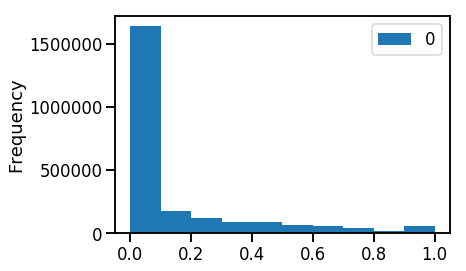

In [51]:
pd.DataFrame(y_test).plot.hist()

In [52]:
print('Test duplicates with >0.9 confidence:', len(df_submission[df_submission.is_duplicate > 0.9]))
print('Test mean prediction:', np.mean(y_test))
print('Calibrated mean prediction:', df_submission['is_duplicate'].mean())

Test duplicates with >0.9 confidence: 50977
Test mean prediction: 0.13191317707235767
Calibrated mean prediction: 0.07926094608141294


In [53]:
#final_cv_score = -scores.mean()
#model_clf = "lgbfull"
#model_clf = 'xgbfull'
#model_clf = "lgb+xgbfull"
#model_clf = "siamese_lstm"
#model_clf = "lrfull"
#model_clf = 'rfcfull'
#model_clf = 'stackfull'
#model_clf = "stackcv"
model_clf = "lgbfullsk"
# model_clf = "stacklgb+xgb"
# model_clf = "stackwithlgb"
# model_clf = "stackwithnoprob"
# model_clf = "stackfinal"
# model_clf = "lgbfull2"
# model_clf = 'lgbrandom'
# model_clf = 'stacking-diverse'

In [54]:
df_submission.to_csv(
    project.submissions_dir + f'{submission_id}-submission-draft-cv-{model_clf}.csv',
    header=True,
    float_format='%.8f',
    index=None,
)